In [9]:
import numpy as np
import astropy.cosmology as cosmo
from matplotlib import pylab as plt
%matplotlib inline

We load Marco's latest matrix, which provides $L(z, E)=\frac{dN}{dE'dtdSdOmegadV}$ where V is the comobile volume and $E'=(1+z)E$ is the rest-frame energy

In [13]:
mat = np.loadtxt("EmissMatrix2.txt",unpack=True)
# array of redshift
z = mat[0,1:]
# array of observed energies
Eobs = mat[1:,0] # GeV
#array of blazar luminosity in the Eaj and z grid.
Emiss = np.nan_to_num(mat[1:,1:])#*1e3 # ph/GeV/cm^2/s/sr/Mpc^3

As a reminder [Hogg Eq. 28]:
$$
   dV_c d\Omega = D_H \frac{(1+z)^2 D_A^2}{E(z)}  dz,
$$
where $D_H = c/H_0$, $E(z)=\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda}$ (we use a flat Universe, $\Omega_k =0$) and $D_A$ is the angular diameter distance define by [Hogg Eq. 18]:
$$
   D_A = \frac{D_M}{1+z},
$$
where $D_M$ is the comoving distance (transverse) which is equal to the comoving distance (line-of-sight) $D_C$ in the case of a flat Universe [Hogg Eq. 16] ($ D_M = D_C $) and $D_C$ is define by [Hogg Eq. 15]:
$$
   D_C = D_H \int_0^z \frac{dz'}{E(z')}
$$
In a flat universe, we also have [Hogg eq.29}:
$$
V_c = \frac{4\pi}{3}D_M^3
$$
SCIPY provides a nice interface to these cosmological quantities :

In [14]:
from astropy.cosmology import FlatLambdaCDM

mycosmo = FlatLambdaCDM(H0=67, Om0=0.3)

dV = mycosmo.differential_comoving_volume(z)
# the integral in scipy is also over solid angle, while the result we want is per sr
V = mycosmo.comoving_volume(z)/4./np.pi 

Now we just need to integrate the function $(1+z)*L(E,z)*dV$ as a function of V or z. The $(1+z)$ factor just cancels the fact that $L$ is given per unit rest-frame energy, while we want the SED in unit observed energy.

In [20]:
from scipy.integrate import simps

#integrating with respect to z
dNtot1 = Emiss * (1+z) * dV
dN_simps1 = simps(dNtot1, z)

#integrating with respect to V
dNtot2 = Emiss * (1+z)
dN_simps2 = simps(dNtot2, V)


and we compare to a curve provided by Marco:

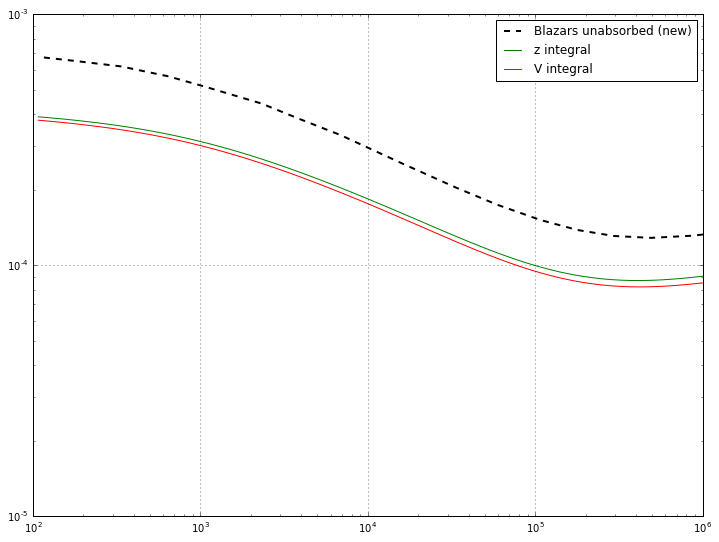

In [28]:
ax0 = plt.figure(figsize=(12,9)).add_subplot(111)

E_aj, E2dNdE_aj = np.loadtxt("../simulation-analysis/Results/Ajello2015-new.csv",delimiter=',',unpack=True)   
ax0.plot(E_aj,E2dNdE_aj,linewidth=2,linestyle="--",color='k',label="Blazars unabsorbed (new)")

from scipy.integrate import simps

ax0.loglog(Eobs, Eobs**2*dN_simps1,color='g',label="z integral")

ax0.loglog(Eobs, Eobs**2*dN_simps2,color='r',label="V integral")


ax0.set_xlim(1e2, 1.e6)
ax0.set_ylim(1.e-5, 1e-3)
ax0.grid()
ax0.legend()

One can see that the 2 integration scheme are not completely identical, nevertheless they give very comparable results, compared to the curve provided by Marco. It appears that there is an additional $(1+z)$ factor in the latter:

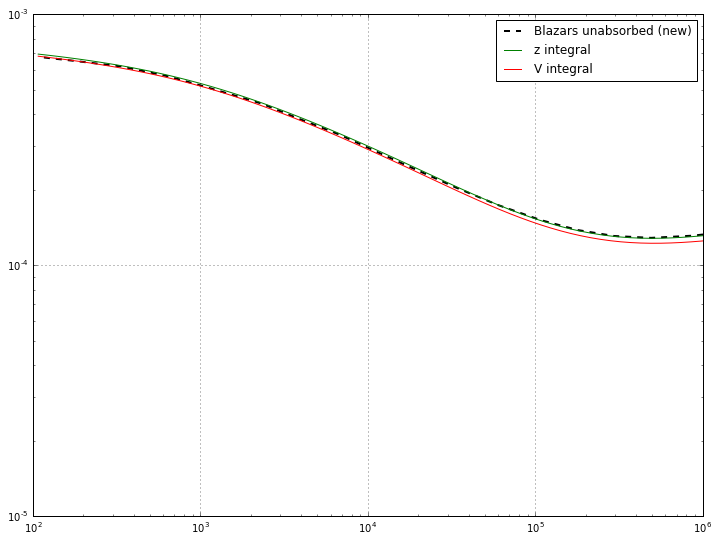

In [27]:
ax1 = plt.figure(figsize=(12,9)).add_subplot(111)

ax1.plot(E_aj,E2dNdE_aj,linewidth=2,linestyle="--",color='k',label="Blazars unabsorbed (new)")

dN_simps1_bis = simps(dNtot1*(1+z), z)

dN_simps2_bis = simps(dNtot2*(1+z), V)

ax1.loglog(Eobs, Eobs**2*dN_simps1_bis,color='g',label="z integral")

ax1.loglog(Eobs, Eobs**2*dN_simps2_bis,color='r',label="V integral")


ax1.set_xlim(1e2, 1.e6)
ax1.set_ylim(1.e-5, 1e-3)
ax1.grid()
ax1.legend()

The z integral is now an excellent match, while the V integral is slightly off at large Eobs. One possibility to explain this $(1+z)$ discrepancy is that the table in the file is not the differential luminosity per z, but per $\log(1+z)$...